In [23]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,WeightedRandomSampler,SubsetRandomSampler, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import torch

### Apply different transforms to augment the dataset

The transforms are done online when called by the DataLoader, so every time its called to generate a batch the transforms are applied randomly,
which allows the model to see the same image differently almost every epoch

In [24]:
train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, fill=128), #augmentation
    transforms.RandomRotation(10), #augmentation
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.5, 1.0), ratio=(0.75, 1.33)), #resizing is essential but cropping is augmentation
    transforms.RandomHorizontalFlip(0.5), #augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1), #augmentation 
    transforms.ToTensor(), #essential
])
val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

Read the data

In [25]:
#Read it twice because each one has different transforms
trainDataset = datasets.ImageFolder(root='StyleClassificationIndoors/train', transform=train_transforms)
valDataset   = datasets.ImageFolder(root='StyleClassificationIndoors/train', transform=val_transforms)

targets = trainDataset.targets
#split by index, not the actual data
train_idx, val_idx = train_test_split(
    np.arange(len(targets)), 
    test_size=0.2,           #80/20 split
    shuffle=True, 
    stratify=targets     #to keep the same distribution of classes in both sets
)

train_subset = Subset(trainDataset, train_idx)
val_subset   = Subset(valDataset, val_idx)


The boho and the minimalist classes are outliers in the terms of number of images. boho: 918, minimalist: 555

In [26]:
counter = Counter(trainDataset.targets)
for class_index, count in counter.most_common():
    class_name = trainDataset.classes[class_index]
    print(f"{class_name}: {count}")

boho: 918
eclectic: 809
modern: 809
farmhouse: 795
coastal: 794
mediterranean: 789
french-country: 788
contemporary: 782
asian: 779
southwestern: 772
tropical: 772
scandinavian: 768
craftsman: 764
industrial: 764
victorian: 759
shabby-chic-style: 746
minimalist: 555


Balance only the training dataset using a weighted random sampler

In [27]:
train_targets = np.array(targets)[train_idx] #get all the training targets

#calculate the weights
class_counts = np.bincount(train_targets)
class_weights = 1. / class_counts

#map each label to its weight
sample_weights = class_weights[train_targets] #this create an array of len(train_targets), and its like every we are indexing by the target label 
sample_weights = torch.from_numpy(sample_weights).double()

train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [28]:
train_loader = DataLoader(
    train_subset, 
    batch_size=32, 
    sampler=train_sampler,
    num_workers=4
)

val_loader = DataLoader(
    val_subset, 
    batch_size=32, 
    shuffle=False,        
    num_workers=4
)

In [29]:
print(f"Training on {len(train_subset)} images.")
print(f"Validating on {len(val_subset)} images.")

Training on 10530 images.
Validating on 2633 images.


### Visualize a batch

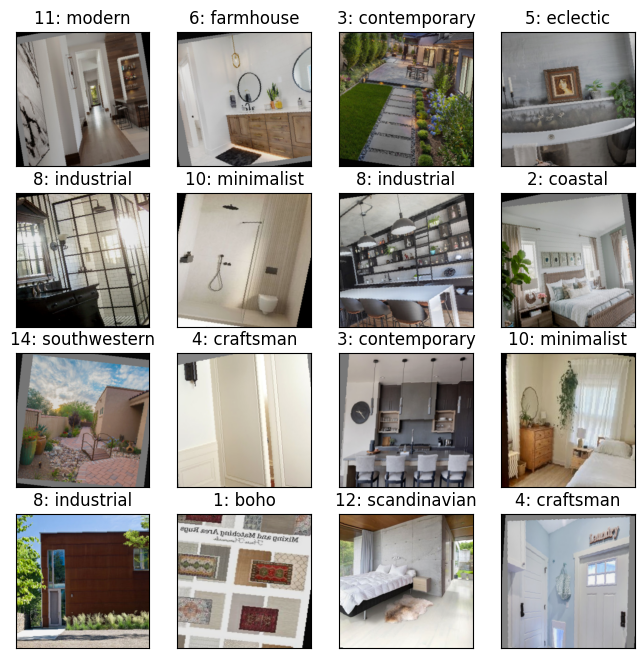

In [35]:
indoorStyleClasses = trainDataset.classes

data_iter = iter(train_loader)
images, labels = next(data_iter)

fig = plt.figure(figsize=(8, 8))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    
    img_display = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img_display)
    idx = labels[i].item()
    real_name = indoorStyleClasses[idx]
    
    ax.set_title(f"{idx}: {real_name}")

plt.show()